<a href="https://colab.research.google.com/github/noyomedicen/Data-analysis---Contabilidad-APP/blob/main/ContabilidadAPP_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importamos las librerias y los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Importamos librerias
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)
import datetime
from datetime import date

In [ ]:
from google.colab import auth
from google.auth import default

try:
  import gspread
except ModuleNotFoundError:
  if 'google.colab' in str(get_ipython()):
    %pip install gspread
  import gspread

auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
#Cargamos archivo de la base de datos con analisis de sentimiento
sheet_name = 'Alegra-Tabla_general'
sheet_id = ''

google_url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv&sheet={sheet_name}"

df = pd.read_csv(google_url)
df_copia = df

## Exploracion y limpieza de datos

In [ ]:
print("Cantidad de registros:", len(df))

Cantidad de registros: 10000


In [ ]:
#Vemos la informacion principal de la tabla (columnas, cantidad de no vacios y tipos de datos)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10000 non-null  int64  
 1   clasificacion             10000 non-null  object 
 2   revenue                   10000 non-null  float64
 3   cost                      10000 non-null  float64
 4   profit                    10000 non-null  float64
 5   profitpercent             10000 non-null  float64
 6   usage_time_total          10000 non-null  float64
 7   usage_time_mean           10000 non-null  float64
 8   most_used_feature_1       10000 non-null  object 
 9   lest_used_feature_1       10000 non-null  object 
 10  feedback_count            10000 non-null  int64  
 11  positive_feedback         10000 non-null  int64  
 12  negative_feedback         10000 non-null  int64  
 13  neutral_feedback          10000 non-null  int64  
 14  feature

Variables a considerar dentro de la base de datos, estas variables serviran para categorizar a los usuarios:

*Categoricas*

* most_used_feature_1
* lest_used_feature_1
* clasificacion

*Numerica*
* revenue
* cost
* profit
* profitpercent
* usage_time_total
* feedback_count






### Variables categoricas
Exploramos las variables categoricas para identificar los valores unicos que se encuentran dentro de ellas:

In [ ]:
print('Conteo de feature, la cuales son las mas utilizada por cada usuario, en funcion del tiempo de uso:\n', df['most_used_feature_1'].value_counts(), "\n")

Conteo de feature, la cuales son las mas utilizada por cada usuario, en funcion del tiempo de uso:
 feature_13    536
feature_9     535
feature_5     529
feature_4     526
feature_20    518
feature_2     518
feature_15    516
feature_14    499
feature_3     497
feature_10    497
feature_8     493
feature_11    493
feature_19    491
feature_12    485
feature_7     484
feature_17    482
feature_1     481
feature_16    478
feature_18    475
feature_6     467
Name: most_used_feature_1, dtype: int64 



In [ ]:
print('Conteo de feature, la cuales son las menos utilizada por cada usuario, en funcion del tiempo de uso:\n', df['lest_used_feature_1'].value_counts(), "\n")

Conteo de feature, la cuales son las menos utilizada por cada usuario, en funcion del tiempo de uso:
 feature_9     542
feature_12    530
feature_7     522
feature_19    514
feature_20    509
feature_8     508
feature_5     507
feature_4     505
feature_3     503
feature_6     502
feature_16    501
feature_2     500
feature_15    500
feature_17    497
feature_11    495
feature_13    494
feature_10    486
feature_1     466
feature_18    462
feature_14    457
Name: lest_used_feature_1, dtype: int64 



### Mediciones estadisticas


Creamos un nuevo dataframe con los valores que nos interesan para realizar la segmentacion.

In [ ]:
#data = df[['most_used_feature_1','lest_used_feature_1','revenue','cost','profit','profitpercent','usage_time_total','usage_time_mean','feedback_count','positive_feedback','negative_feedback','neutral_feedback']]
data = df[['clasificacion','most_used_feature_1','lest_used_feature_1','revenue','cost','profit','profitpercent','usage_time_total','feedback_count']]
data

,clasificacion,most_used_feature_1,lest_used_feature_1,revenue,cost,profit,profitpercent,usage_time_total,feedback_count
0,Excelente,feature_19,feature_15,427.56,146.39,281.17,65.76,79.71,0
1,Bueno,feature_3,feature_7,231.58,121.61,109.97,47.49,106.16,1
2,Bueno,feature_14,feature_16,403.36,175.51,227.85,56.49,54.49,3
3,Critico,feature_13,feature_3,119.88,236.75,-116.87,-97.49,69.22,1
4,Excelente,feature_11,feature_9,498.81,64.94,433.88,86.98,47.64,0
...,...,...,...,...,...,...,...,...,...
9995,Bueno,feature_8,feature_1,425.73,180.54,245.20,57.59,48.92,1
9996,Excelente,feature_8,feature_16,1228.55,329.44,899.10,73.18,45.36,2
9997,Excelente,feature_6,feature_8,415.12,99.29,315.83,76.08,87.56,0
9998,Bueno,feature_18,feature_10,690.61,345.30,345.31,50.00,86.23,1


Reemplazamos la coma por el punto, dentro de las variables siguintes:

In [ ]:
#data['revenue'] = data['revenue'].apply(lambda x: x.replace(",", "."))
#data['cost'] = data['cost'].apply(lambda x: x.replace(",", "."))
#data['profit'] = data['profit'].apply(lambda x: x.replace(",", "."))
#data['profitpercent'] = data['profitpercent'].apply(lambda x: x.replace(",", "."))
#data['usage_time_total'] = data['usage_time_total'].apply(lambda x: x.replace(",", "."))
#data['usage_time_mean'] = data['usage_time_mean'].apply(lambda x: x.replace(",", "."))

Transformamos en variables flot las anteriores:

In [ ]:
data['revenue'] = data['revenue'].astype(float)
data['cost'] = data['cost'].astype(float)
data['profit'] = data['profit'].astype(float)
data['profitpercent'] = data['profitpercent'].astype(float)
data['usage_time_total'] = data['usage_time_total'].astype(float)
#data['usage_time_mean'] = data['usage_time_mean'].astype(float)

<ipython-input-11-9d5f6ee8ff18>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['revenue'] = data['revenue'].astype(float)
<ipython-input-11-9d5f6ee8ff18>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['cost'] = data['cost'].astype(float)
<ipython-input-11-9d5f6ee8ff18>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

Vemos la estadistica de las variables numericas.

In [ ]:
data.describe()

,revenue,cost,profit,profitpercent,usage_time_total,feedback_count
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,549.563284,218.241286,331.322003,55.156352,71.741436,1.500000
std,288.177069,114.558939,227.796562,24.715599,39.253687,1.232052
min,0.000000,0.000000,-346.030000,-304.920000,0.850000,0.000000
25%,337.425000,136.265000,162.982500,46.147500,43.962500,1.000000
50%,513.290000,204.305000,297.365000,60.220000,63.910000,1.000000
75%,722.930000,286.170000,468.235000,70.610000,91.492500,2.000000
max,2250.000000,821.030000,1729.140000,97.710000,317.100000,8.000000


In [ ]:
#Definimos la configuracion para las graficas que usaremos mas adelante
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#00b19d", "#9fa8da", "#bfcd31", "#4a90e2", "#e0e0e0","#008bb0", "#cb5cde"]
cmap = colors.ListedColormap(["#00b19d", "#9fa8da", "#bfcd31", "#4a90e2", "#e0e0e0","#008bb0", "#cb5cde"])

Grafica de algunas variables


/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1513: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  func(x=vector, **plot_kwargs)


<Figure size 800x550 with 0 Axes>

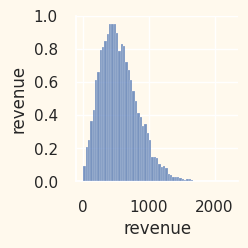

In [ ]:
#Graficamos algunas variables
To_Plot = ['revenue']
print("Grafica de algunas variables")
plt.figure()
sns.pairplot(data[To_Plot], palette= (["#682F2F","#F3AB60"]))
plt.show()

<ipython-input-15-4b70e59e4717>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrmat= data.corr()


<Axes: >

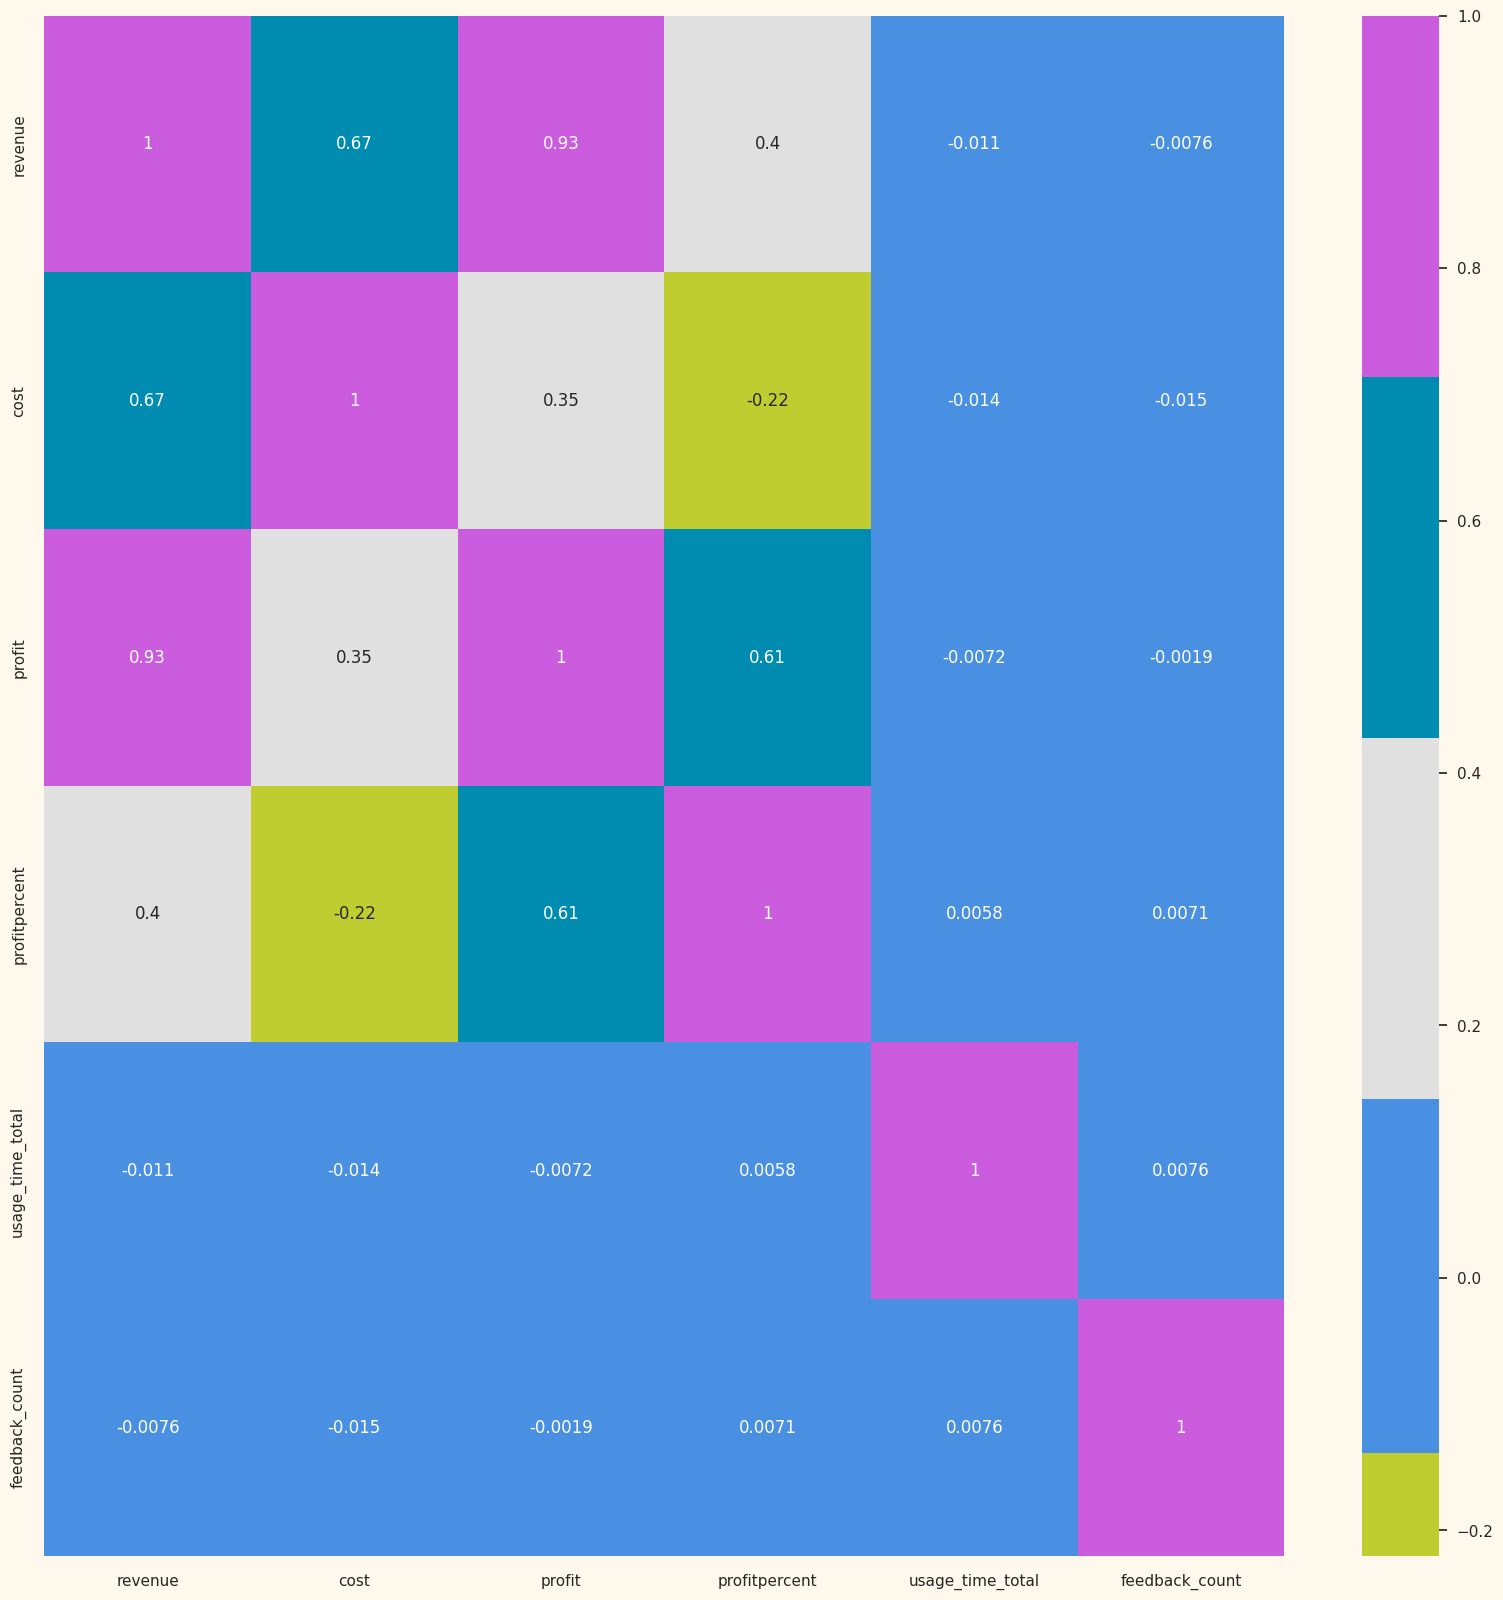

In [ ]:
#Matriz de Correlacion
corrmat= data.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)

## Procesamiento de los datos

In [ ]:
#Obtenemos una lista de las variables categoricas
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Variables categoricas en el dataset:", object_cols)

Variables categoricas en el dataset: ['clasificacion', 'most_used_feature_1', 'lest_used_feature_1']


In [ ]:
#Etiquetamos cada una de las variables categoricas con un codigo
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

print("Todas las variables son ahora numericas")

Todas las variables son ahora numericas


<ipython-input-17-de278eebf1dd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i]=data[[i]].apply(LE.fit_transform)
<ipython-input-17-de278eebf1dd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[i]=data[[i]].apply(LE.fit_transform)
<ipython-input-17-de278eebf1dd>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [ ]:
data

,clasificacion,most_used_feature_1,lest_used_feature_1,revenue,cost,profit,profitpercent,usage_time_total,feedback_count
0,2,10,6,427.56,146.39,281.17,65.76,79.71,0
1,0,13,17,231.58,121.61,109.97,47.49,106.16,1
2,0,5,7,403.36,175.51,227.85,56.49,54.49,3
3,1,4,13,119.88,236.75,-116.87,-97.49,69.22,1
4,2,2,19,498.81,64.94,433.88,86.98,47.64,0
...,...,...,...,...,...,...,...,...,...
9995,0,18,0,425.73,180.54,245.20,57.59,48.92,1
9996,2,18,7,1228.55,329.44,899.10,73.18,45.36,2
9997,2,16,18,415.12,99.29,315.83,76.08,87.56,0
9998,0,9,1,690.61,345.30,345.31,50.00,86.23,1


In [ ]:
#Creamos una copia de los datos
ds = data.copy()
#Escalamos los datos
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("Todas las variables ahora están escaladas")

Todas las variables ahora están escaladas


In [ ]:
#Datos escalados que se utilizarán para reducir la dimensionalidad.
print("Dataframe escalado que se utilizara para realizar el modelado")
scaled_ds.head()

Dataframe escalado que se utilizara para realizar el modelado


,clasificacion,most_used_feature_1,lest_used_feature_1,revenue,cost,profit,profitpercent,usage_time_total,feedback_count
0,0.823328,0.078511,-0.627462,-0.423383,-0.627231,-0.220172,0.429048,0.203012,-1.217542
1,-1.124916,0.598796,1.275092,-1.103485,-0.843549,-0.971758,-0.310198,0.876868,-0.405847
2,-1.124916,-0.788631,-0.454503,-0.507364,-0.373026,-0.454253,0.053962,-0.439508,1.217542
3,-0.150794,-0.962059,0.583254,-1.491114,0.161573,-1.967608,-6.176423,-0.064238,-0.405847
4,0.823328,-1.308916,1.621011,-0.176127,-1.338254,0.450240,1.287658,-0.614022,-1.217542


In [ ]:
scaled_ds

,clasificacion,most_used_feature_1,lest_used_feature_1,revenue,cost,profit,profitpercent,usage_time_total,feedback_count
0,0.823328,0.078511,-0.627462,-0.423383,-0.627231,-0.220172,0.429048,0.203012,-1.217542
1,-1.124916,0.598796,1.275092,-1.103485,-0.843549,-0.971758,-0.310198,0.876868,-0.405847
2,-1.124916,-0.788631,-0.454503,-0.507364,-0.373026,-0.454253,0.053962,-0.439508,1.217542
3,-0.150794,-0.962059,0.583254,-1.491114,0.161573,-1.967608,-6.176423,-0.064238,-0.405847
4,0.823328,-1.308916,1.621011,-0.176127,-1.338254,0.450240,1.287658,-0.614022,-1.217542
...,...,...,...,...,...,...,...,...,...
9995,-1.124916,1.465938,-1.665219,-0.429734,-0.329116,-0.378084,0.098471,-0.581412,-0.405847
9996,0.823328,1.465938,-0.454503,2.356262,0.970717,2.492603,0.729278,-0.672109,0.405847
9997,0.823328,1.119081,1.448051,-0.466553,-1.038393,-0.068011,0.846619,0.403003,-1.217542
9998,-1.124916,-0.094917,-1.492260,0.489469,1.109168,0.061409,-0.208638,0.369119,-0.405847


In [ ]:
#Removemos las filas con valores vacios, para evitar problemas mas adelante
scaled_ds = scaled_ds.dropna()
print("El numero de filas que quedan luego de remover las filas vacias son las siguientes:", len(data))

El numero de filas que quedan luego de remover las filas vacias son las siguientes: 10000


# Reduccion de las dimenciones

Hay distintas variables que se tomaran en cuenta para realizar la clasificación final. Estas variables son básicamente atributos o características. Cuanto mayor sea el número de características, más difícil será trabajar. Muchas de estas características están correlacionadas y, por lo tanto, son redundantes.

Es por eso que se realiza una reducción de dimensionalidad en las características seleccionadas antes de pasarlas por el algoritmo de clusterizacion. "La reducción de dimensionalidad es el proceso de reducir el número de variables aleatorias bajo consideración, mediante la obtención de un conjunto de variables principales."

El análisis de componentes principales (PCA) es una técnica para reducir la dimensionalidad de dichos conjuntos de datos, aumentando la interpretabilidad pero al mismo tiempo minimizando la pérdida de información.

Pasos en esta sección:

* Reducción de dimensionalidad con PCA
* Trazado del marco de datos reducido
* Reducción de dimensionalidad con PCA

Para este caso, se reduciran las dimensiones a 3.

In [ ]:
#Iniciando PCA para reducir las dimensiones a 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,10000.0,-1.421085e-18,1.611027,-8.159458,-1.121230,-0.123058,1.027746,8.232075
col2,10000.0,1.989520e-17,1.260286,-2.877404,-0.998435,-0.052661,0.888436,5.615796
col3,10000.0,3.410605e-17,1.033324,-2.693566,-0.776700,0.012702,0.769218,2.724143


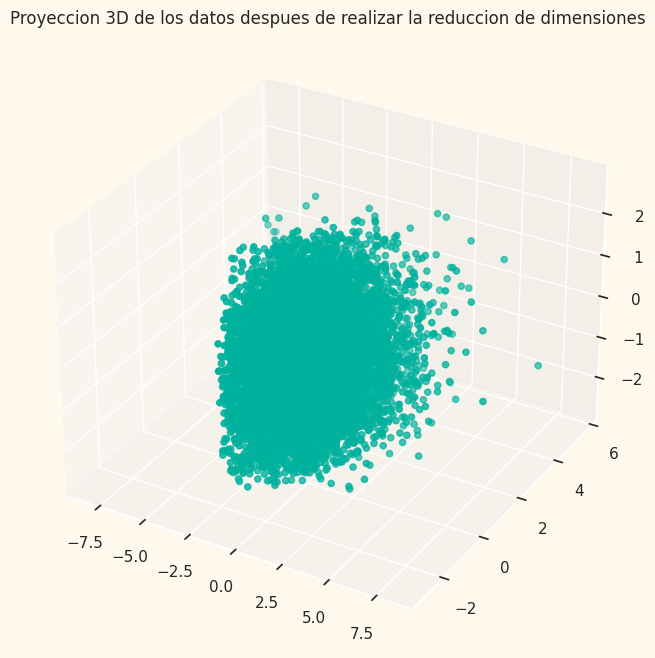

In [ ]:
#Proyeccion 3D de los datos despues de realizar la reduccion de dimensiones
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#Graficamos
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="#00b19d", marker="o" )
ax.set_title("Proyeccion 3D de los datos despues de realizar la reduccion de dimensiones")
plt.show()

# Clustering de los datos

Clusterizacion

Ahora que se han reducido los atributos a tres dimensiones, correremos el modelo de clasificacion a través de la clusterizacion aglomerativo. La clusterizacion aglomerativa es un método de agrupamiento jerárquico. Implica fusionar ejemplos hasta lograr el número deseado de grupos.

Pasos involucrados en el Clustering

* Método de Elbow para determinar el número de clusters optimos a crear
* Clustering a través de Clustering Aglomerativo
* Examinar los grupos formados a través de un diagrama de dispersión


Metodo Elbow para determinar el numero de clusters que deben de ser formados:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

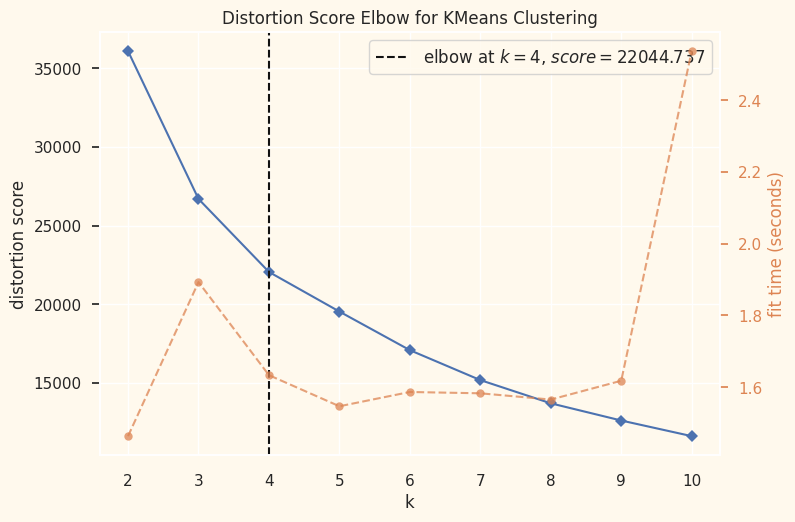

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
#Examen rápido del método "elbow"  para encontrar el número de grupos a realizar.
print('Metodo Elbow para determinar el numero de clusters que deben de ser formados:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

La celda anterior indica que cuatro será un número óptimo de grupos para estos datos. A continuación, ajustaremos el modelo de agrupamiento aglomerativo para obtener los agrupamientos finales.

In [ ]:
#Iniciamos el modelo de Clustering Aglomerativo con 4 clusters
AC = AgglomerativeClustering(n_clusters=4)
#Ajustar el modelo y predecir los clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Removemos las filas con valores vacios, para evitar problemas mas adelante
data = data.dropna()
#Agreganto los cluster al original dataframe
data["Clusters"]= yhat_AC

Graficamos los clusters formados, para tener un entendimiento de como el algoritmo los clasifico.

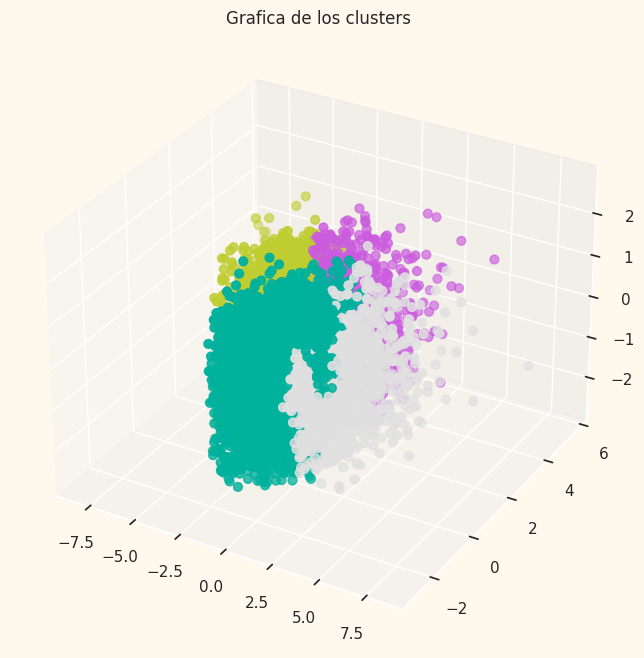

In [ ]:
#Graficamos los clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("Grafica de los clusters")
plt.show()

# Evaluacion del modelo

Dado que se trata de un agrupamiento no supervisado. No tenemos una característica previa para evaluar o puntuar el desempeño de nuestro modelo. El propósito de esta sección es analizar los patrones de cada cluster o grupo.

Para eso, realizamos un analisis exploratorio de datos y sacamos las primeras conclusiones.

Primero comenzamos a ver la distribucion de cada uno de los clusters.

<ipython-input-53-e3f19c337ee9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Clusters"], palette= pal)


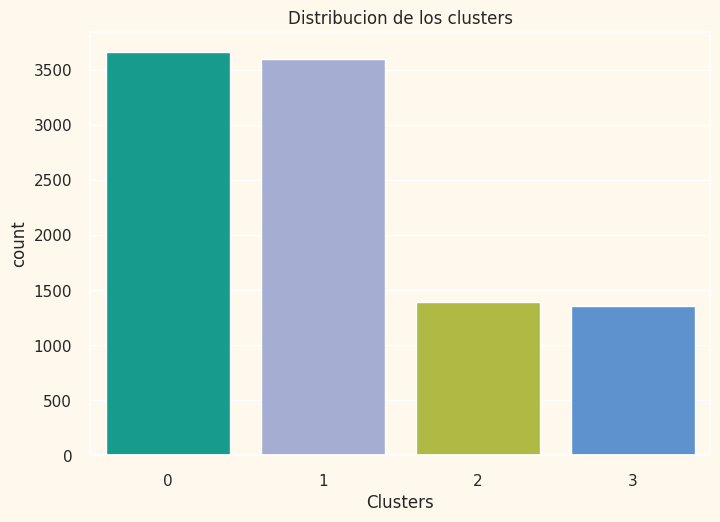

In [ ]:
#Graficamos la distribucion de los clusters
pal = ["#00b19d", "#9fa8da", "#bfcd31", "#4a90e2"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribucion de los clusters")
plt.show()

* most_used_feature_1
* lest_used_feature_1

*Numerica*
* revenue
* cost
* profit
* profitpercent
* usage_time_total
* feedback_count



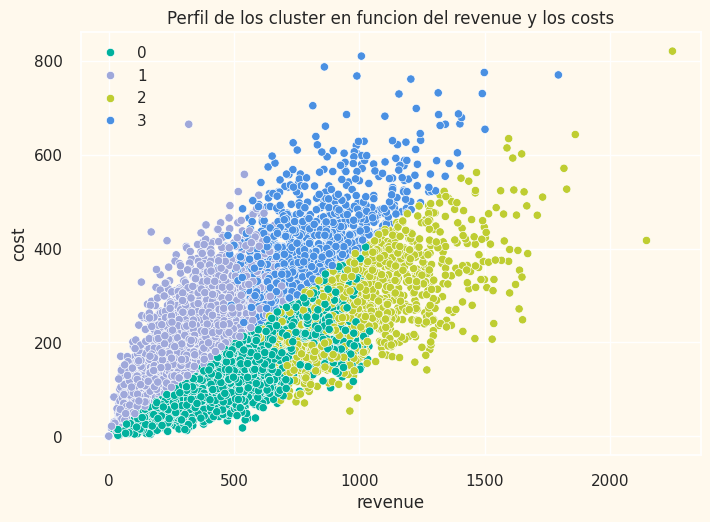

In [ ]:
pl = sns.scatterplot(data = data,x=data["revenue"], y=data["cost"],hue=data["Clusters"], palette= pal)
pl.set_title("Perfil de los cluster en funcion del revenue y los costs")
plt.legend()
plt.show()

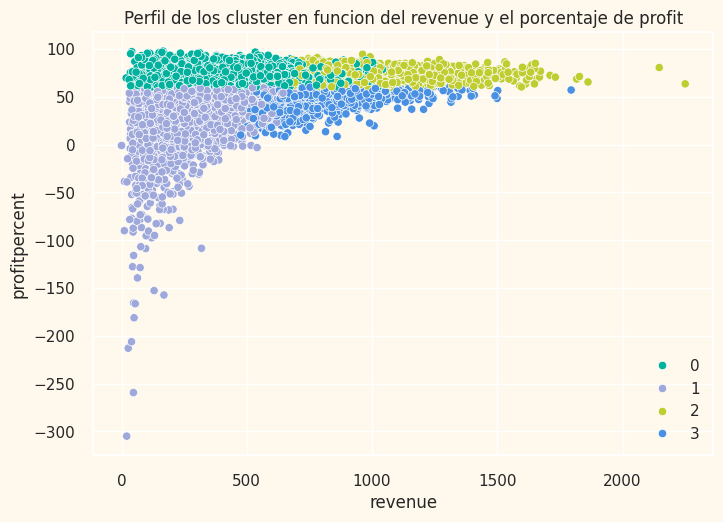

In [ ]:
pl = sns.scatterplot(data = data,x=data["revenue"], y=data["profitpercent"],hue=data["Clusters"], palette= pal)
pl.set_title("Perfil de los cluster en funcion del revenue y el porcentaje de profit")
plt.legend()
plt.show()

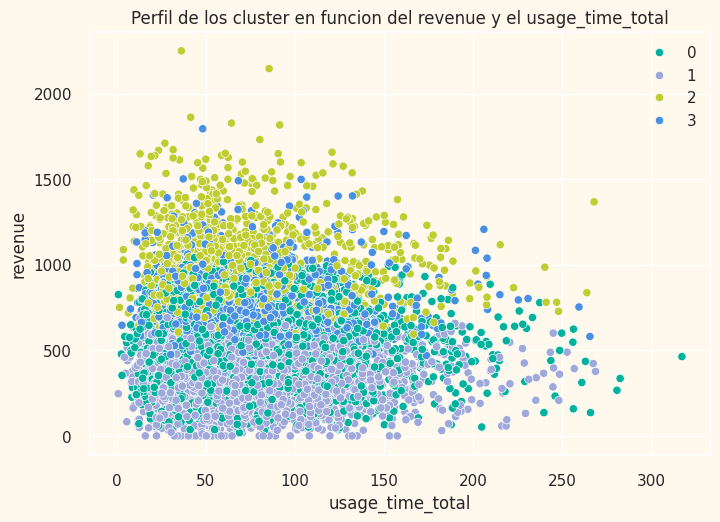

In [ ]:
pl = sns.scatterplot(data = data,x=data["usage_time_total"], y=data["revenue"],hue=data["Clusters"], palette= pal)
pl.set_title("Perfil de los cluster en funcion del revenue y el usage_time_total")
plt.legend()
plt.show()

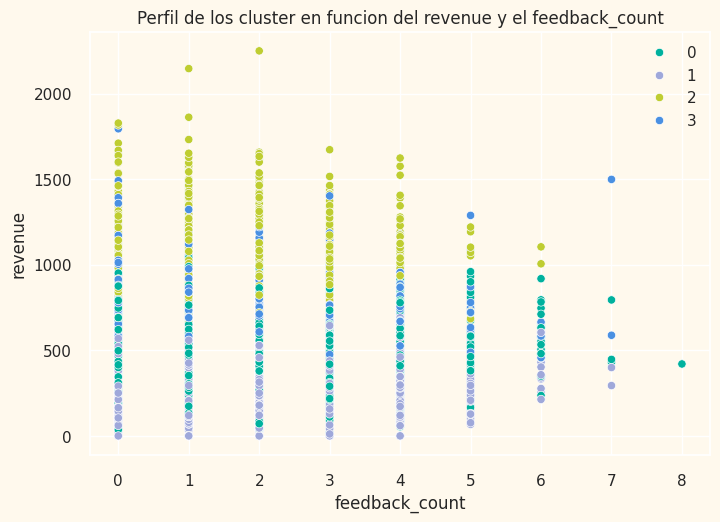

In [ ]:
pl = sns.scatterplot(data = data,x=data["feedback_count"], y=data["revenue"],hue=data["Clusters"], palette= pal)
pl.set_title("Perfil de los cluster en funcion del revenue y el feedback_count")
plt.legend()
plt.show()

<ipython-input-41-c6fbe92b9f90>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["usage_time_total"],x=data["Clusters"], palette= pal)


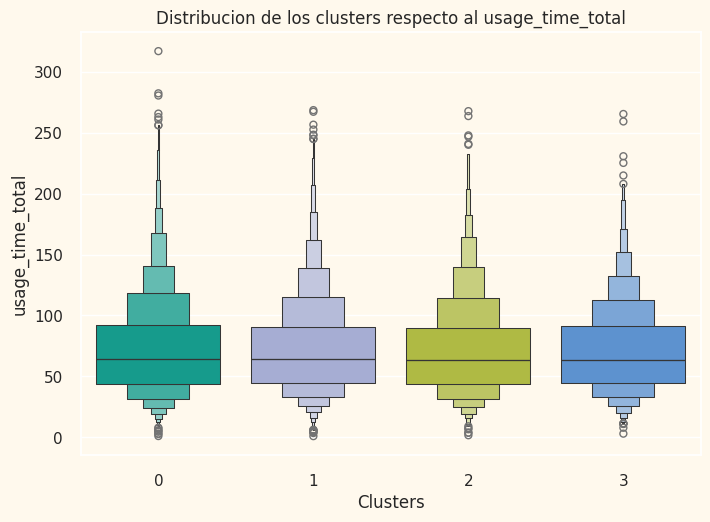

In [ ]:
plt.figure()
pl=sns.boxenplot(y=data["usage_time_total"],x=data["Clusters"], palette= pal)
pl.set_title("Distribucion de los clusters respecto al usage_time_total")
plt.show()

<ipython-input-42-014f43cadab0>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["feedback_count"],x=data["Clusters"], palette= pal)


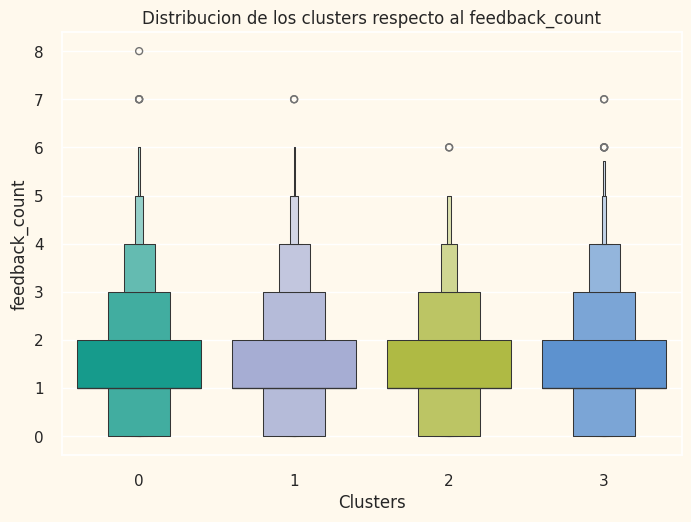

In [ ]:
plt.figure()
pl=sns.boxenplot(y=data["feedback_count"],x=data["Clusters"], palette= pal)
pl.set_title("Distribucion de los clusters respecto al feedback_count")
plt.show()

<ipython-input-46-7e80874ff612>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["most_used_feature_1"],x=data["Clusters"], palette= pal)


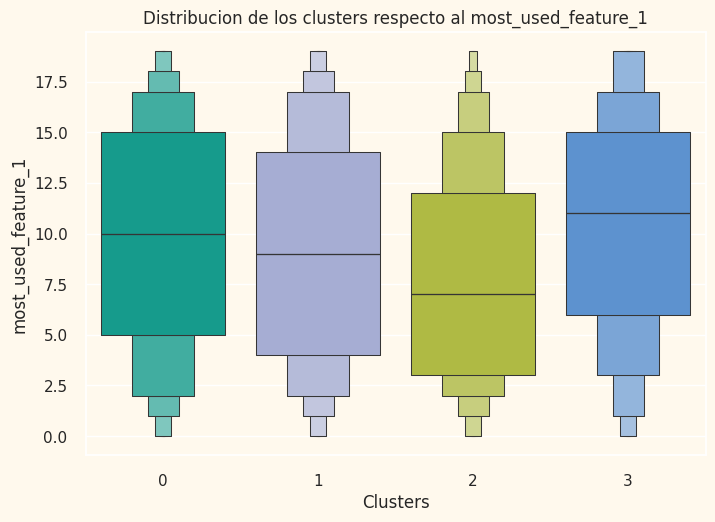

In [ ]:
plt.figure()
pl=sns.boxenplot(y=data["most_used_feature_1"],x=data["Clusters"], palette= pal)
pl.set_title("Distribucion de los clusters respecto al most_used_feature_1")
plt.show()

<ipython-input-48-573a08a2d40f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["lest_used_feature_1"],x=data["Clusters"], palette= pal)


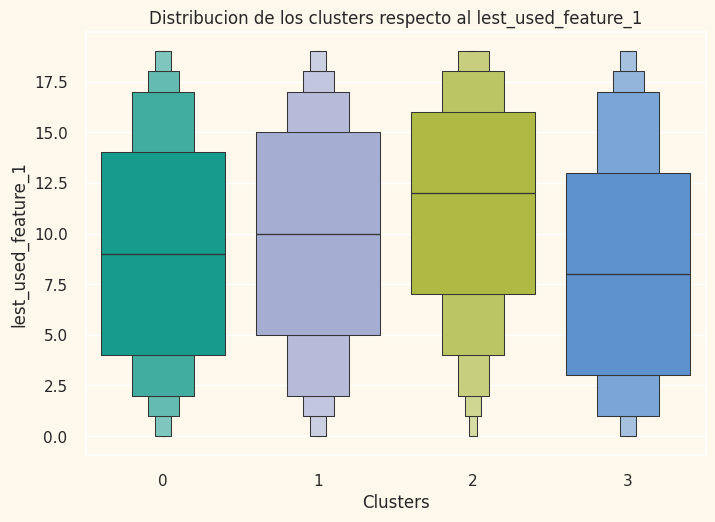

In [ ]:
plt.figure()
pl=sns.boxenplot(y=data["lest_used_feature_1"],x=data["Clusters"], palette= pal)
pl.set_title("Distribucion de los clusters respecto al lest_used_feature_1")
plt.show()

<ipython-input-49-0f34c6c01bd2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["revenue"],x=data["Clusters"], palette= pal)


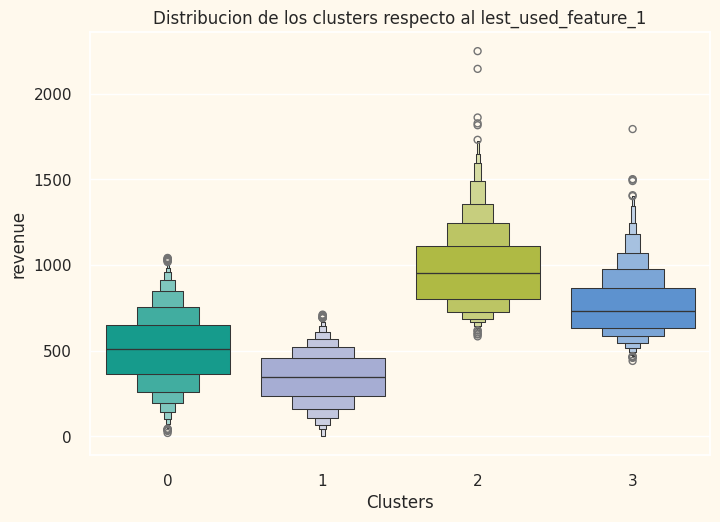

In [ ]:
plt.figure()
pl=sns.boxenplot(y=data["revenue"],x=data["Clusters"], palette= pal)
pl.set_title("Distribucion de los clusters respecto al lest_used_feature_1")
plt.show()

<ipython-input-50-5841fdfa6e7a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["cost"],x=data["Clusters"], palette= pal)


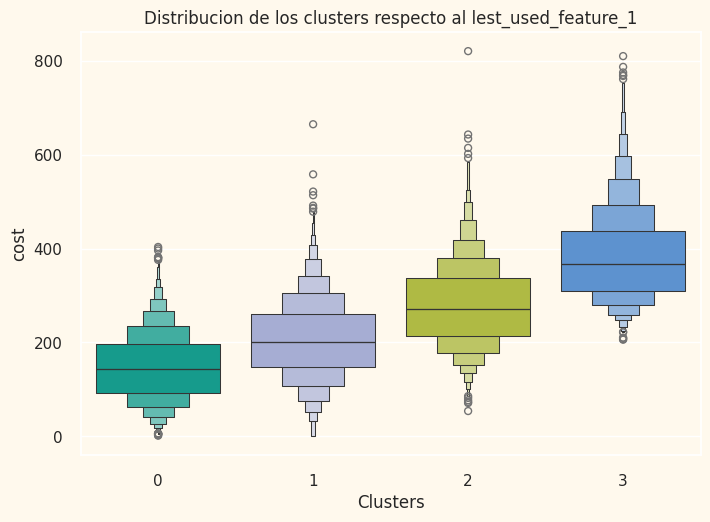

In [ ]:
plt.figure()
pl=sns.boxenplot(y=data["cost"],x=data["Clusters"], palette= pal)
pl.set_title("Distribucion de los clusters respecto al lest_used_feature_1")
plt.show()

# Perfilando los Clusters

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:1883: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(x=self.x, ax=self.ax_marg_x, **kwargs)


<Figure size 800x550 with 0 Axes>

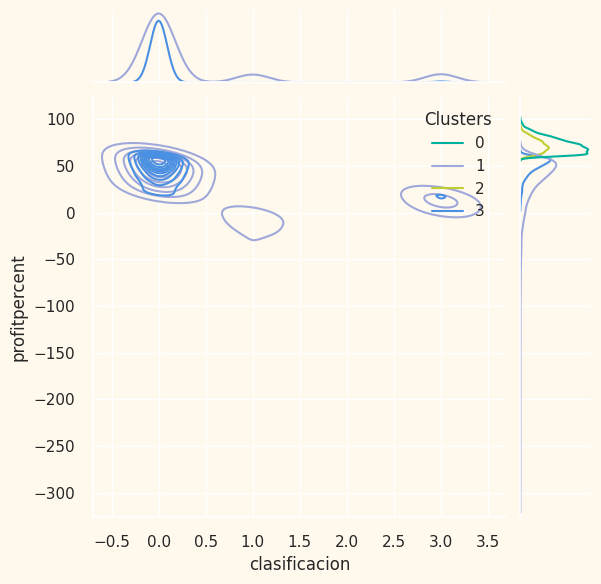

<Figure size 800x550 with 0 Axes>

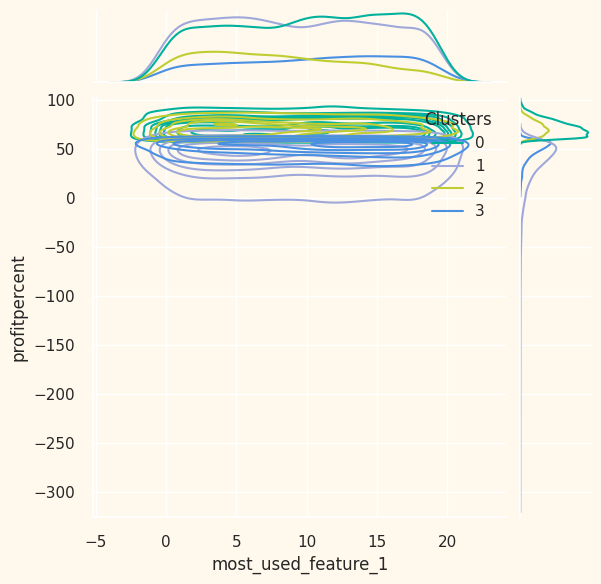

<Figure size 800x550 with 0 Axes>

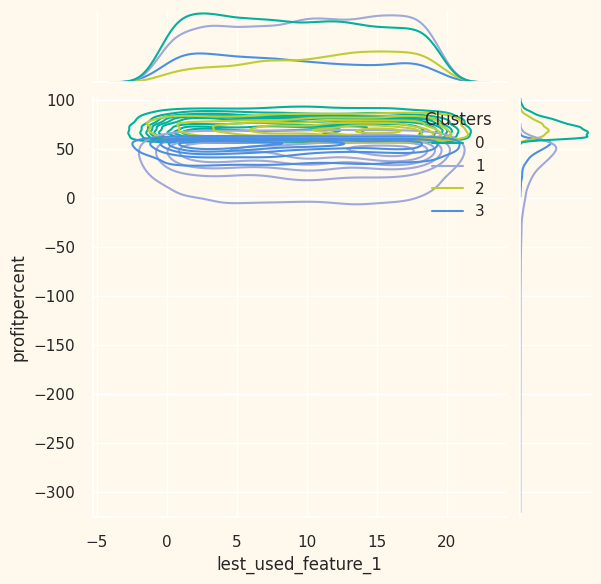

<Figure size 800x550 with 0 Axes>

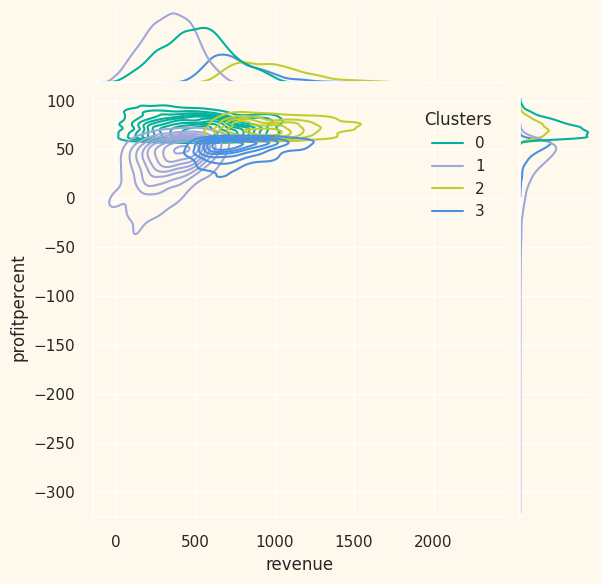

<Figure size 800x550 with 0 Axes>

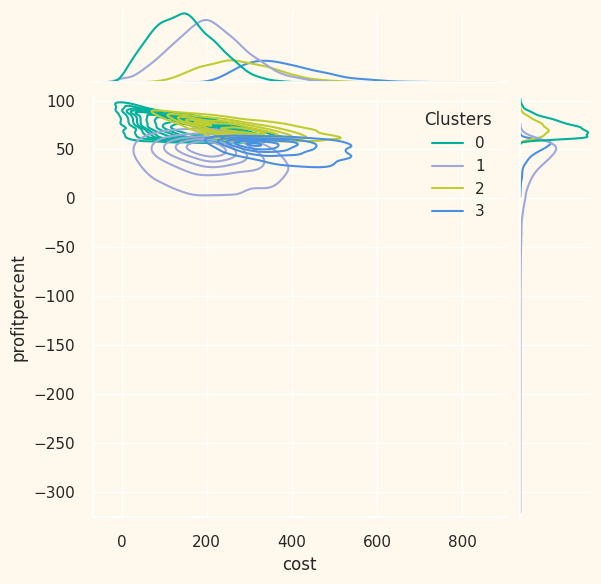

<Figure size 800x550 with 0 Axes>

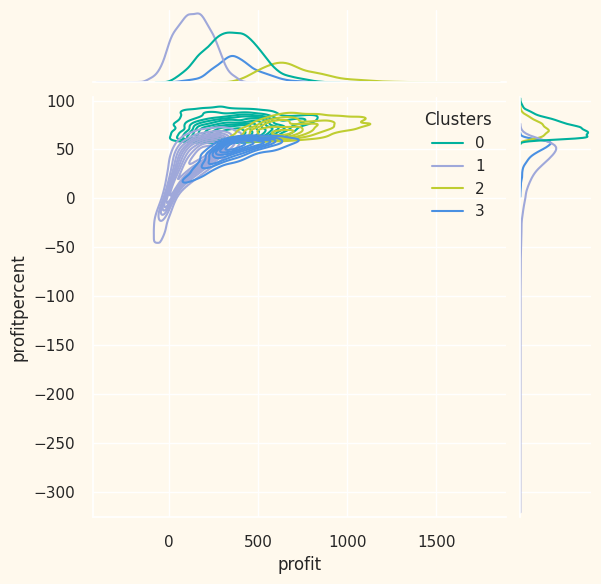

<Figure size 800x550 with 0 Axes>

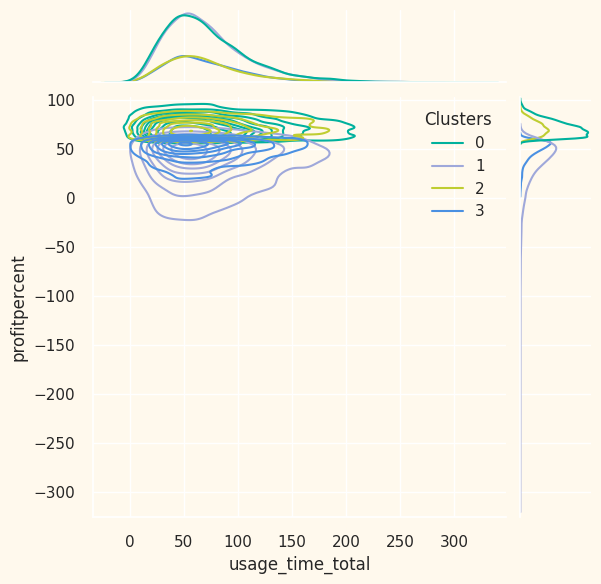

<Figure size 800x550 with 0 Axes>

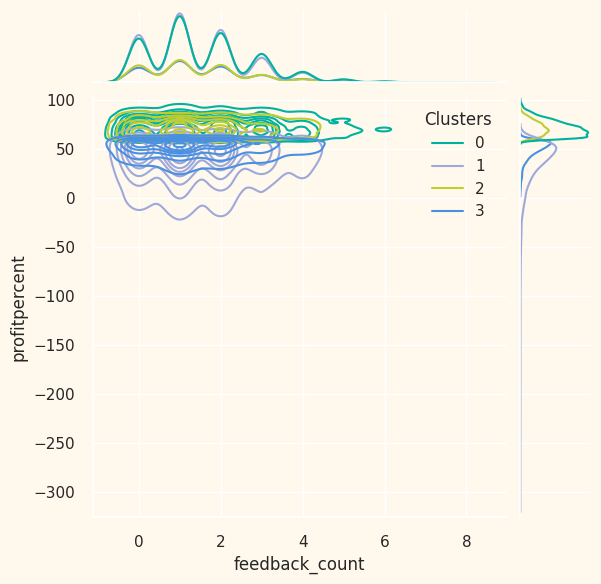

In [ ]:
Personal = ['clasificacion','most_used_feature_1','lest_used_feature_1','revenue','cost','profit','usage_time_total','feedback_count']

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data['profitpercent'], hue =data["Clusters"], kind="kde", palette=pal)
    plt.show()